#### Part 1: The Provided Datasets

##### Step 1: Check the datasets

In [1859]:
# import libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import zarr 
import gcsfs
import cdsapi
import climetlab as cml

In [1861]:
# Load all six datasets
file_paths = [
    "/Users/taniadiamanta/UOM/Semester 2/EarthAndEnvironmentalDS/Coursework2/003_2006_2080_352_360.nc",
    "/Users/taniadiamanta/UOM/Semester 2/EarthAndEnvironmentalDS/Coursework2/004_2006_2080_352_360.nc",
    "/Users/taniadiamanta/UOM/Semester 2/EarthAndEnvironmentalDS/Coursework2/005_2006_2080_352_360.nc",
    "/Users/taniadiamanta/UOM/Semester 2/EarthAndEnvironmentalDS/Coursework2/006_2006_2080_352_360.nc",
    "/Users/taniadiamanta/UOM/Semester 2/EarthAndEnvironmentalDS/Coursework2/007_2006_2080_352_360.nc",
    "/Users/taniadiamanta/UOM/Semester 2/EarthAndEnvironmentalDS/Coursework2/008_2006_2080_352_360.nc"
]

In [1863]:
# Open datasets without decoding time (to handle potential "noleap" calendar issues)
dataset = [xr.open_dataset(fp, decode_times=False) for fp in file_paths]

In [1864]:
# Check the structure of each dataset
dataset_info = {f"Dataset {i+1}": ds.dims for i, ds in enumerate(dataset)}
dataset_info

{'Dataset 1': FrozenMappingWarningOnValuesAccess({'time': 27374, 'lat': 11, 'lon': 6}),
 'Dataset 2': FrozenMappingWarningOnValuesAccess({'time': 27374, 'lat': 11, 'lon': 6}),
 'Dataset 3': FrozenMappingWarningOnValuesAccess({'time': 27374, 'lat': 11, 'lon': 6}),
 'Dataset 4': FrozenMappingWarningOnValuesAccess({'time': 27374, 'lat': 11, 'lon': 6}),
 'Dataset 5': FrozenMappingWarningOnValuesAccess({'time': 27374, 'lat': 11, 'lon': 6}),
 'Dataset 6': FrozenMappingWarningOnValuesAccess({'time': 27374, 'lat': 11, 'lon': 6})}

In [1865]:
# Check dimension consistency

# Extract time, latitude, and longitude from the first dataset as reference
time_ref = dataset[0]["time"].values
lat_ref = dataset[0]["lat"].values
lon_ref = dataset[0]["lon"].values

# Check if all datasets match the first one
time_match = all(np.array_equal(ds["time"].values, time_ref) for ds in dataset)
lat_match = all(np.array_equal(ds["lat"].values, lat_ref) for ds in dataset)
lon_match = all(np.array_equal(ds["lon"].values, lon_ref) for ds in dataset)

# Print results
print("All datasets have identical TIME values:", time_match)
print("All datasets have identical LATITUDE values:", lat_match)
print("All datasets have identical LONGITUDE values:", lon_match)

# If any mismatch occurs, print differences
if not time_match:
    print("Time values differ between datasets!")

if not lat_match:
    print("Latitude values differ between datasets!")

if not lon_match:
    print("Longitude values differ between datasets!")

All datasets have identical TIME values: True
All datasets have identical LATITUDE values: True
All datasets have identical LONGITUDE values: True


In [1868]:
# Check variables in each dataset
dataset_variables = {f"Dataset {i+1}": list(ds.data_vars.keys()) for i, ds in enumerate(dataset)}
dataset_variables

{'Dataset 1': ['TREFMXAV_U',
  'FLNS',
  'FSNS',
  'PRECT',
  'PRSN',
  'QBOT',
  'TREFHT',
  'UBOT',
  'VBOT'],
 'Dataset 2': ['TREFMXAV_U',
  'FLNS',
  'FSNS',
  'PRECT',
  'PRSN',
  'QBOT',
  'TREFHT',
  'UBOT',
  'VBOT'],
 'Dataset 3': ['TREFMXAV_U',
  'FLNS',
  'FSNS',
  'PRECT',
  'PRSN',
  'QBOT',
  'TREFHT',
  'UBOT',
  'VBOT'],
 'Dataset 4': ['TREFMXAV_U',
  'FLNS',
  'FSNS',
  'PRECT',
  'PRSN',
  'QBOT',
  'TREFHT',
  'UBOT',
  'VBOT'],
 'Dataset 5': ['TREFMXAV_U',
  'FLNS',
  'FSNS',
  'PRECT',
  'PRSN',
  'QBOT',
  'TREFHT',
  'UBOT',
  'VBOT'],
 'Dataset 6': ['TREFMXAV_U',
  'FLNS',
  'FSNS',
  'PRECT',
  'PRSN',
  'QBOT',
  'TREFHT',
  'UBOT',
  'VBOT']}

In [1870]:
# Check if the datasets contain different values (i.e. TREFHT)
trefht_values = {f"Dataset {i+1}": dataset[i]["TREFHT"].isel(time=0, lat=0, lon=0).values for i in range(len(dataset))}
trefht_values

{'Dataset 1': array(284.35727, dtype=float32),
 'Dataset 2': array(285.58368, dtype=float32),
 'Dataset 3': array(285.13437, dtype=float32),
 'Dataset 4': array(285.5402, dtype=float32),
 'Dataset 5': array(284.9242, dtype=float32),
 'Dataset 6': array(285.83524, dtype=float32)}

The datasets represent the same spatial and temporal coverage.
- time: 27374
- lat: 11
- lon: 6

The variables are all the same.
- TREFHT: Daily avg near-surface air temperature
- TREFMXAV_U: Daily max near-surface temperature
- FSNS: Net shortwave solar flux at the surface
- FLNS: Net longwave flux at the surface
- PRECT: Precipitation rate
- PRSN: Snowfall rate
- QBOT: Specific humidity at the lowest model level
- UBOT: Zonal wind (east-west) components at the lowest model level
- VBOT: Meridional wind (north-south) components at the lowest model level

However they contain slightly different values, indicating ensemble/multiple runs of the same simulations. Each run starts with slightly different initial conditions or parameter settings but follows the same physical rules. If we use just one ensemble run, it may not represent the full climate trend. So we should average them to:
- reduce random variability
- enhance robustness
- improve comparisons with external datasets like CMIP6 data, which uses multi-model ensembles (averaging across models)

There are also other approaches that serve different purposes:
- Compute standard deviation if you want to measure uncertainty.
- Use min/max values if you are interested in worst/best-case scenarios.

Our intention is to make these datasets more comparable especially with external datasets. Taking the mean would be the safest approach.

##### Step 2: Compute the ensemble mean & merge the datasets

In [1875]:
# Avergae all six datasets
merged_dataset = xr.concat(dataset, dim="ensemble").mean(dim="ensemble")

# Check structure of merged dataset
print(merged_dataset)

<xarray.Dataset> Size: 65MB
Dimensions:     (time: 27374, lat: 11, lon: 6)
Coordinates:
  * lat         (lat) float32 44B 49.48 50.42 51.36 52.3 ... 57.02 57.96 58.9
  * lon         (lon) float32 24B 352.5 353.8 355.0 356.2 357.5 358.8
  * time        (time) float32 109kB 1.0 2.0 3.0 ... 2.737e+04 2.737e+04
Data variables:
    TREFMXAV_U  (time, lat, lon) float32 7MB nan nan nan nan ... 283.3 nan nan
    FLNS        (time, lat, lon) float32 7MB 40.86 40.79 37.88 ... 65.62 63.85
    FSNS        (time, lat, lon) float32 7MB 30.44 25.66 25.82 ... 7.944 8.096
    PRECT       (time, lat, lon) float32 7MB 3.643e-08 4.111e-08 ... 4.56e-08
    PRSN        (time, lat, lon) float32 7MB 4.181e-16 3.793e-16 ... 3.379e-14
    QBOT        (time, lat, lon) float32 7MB 0.007071 0.006948 ... 0.00499
    TREFHT      (time, lat, lon) float32 7MB 285.2 284.9 284.5 ... 282.1 282.3
    UBOT        (time, lat, lon) float32 7MB 8.525 7.8 6.794 ... 3.484 4.03 5.01
    VBOT        (time, lat, lon) float32 7MB 3

In [1876]:
# Save the merged dataset
merged_dataset.to_netcdf("merged_dataset.nc")

In [1877]:
merged_dataset

<xarray.Dataset> Size: 65MB
Dimensions:     (time: 27374, lat: 11, lon: 6)
Coordinates:
  * lat         (lat) float32 44B 49.48 50.42 51.36 52.3 ... 57.02 57.96 58.9
  * lon         (lon) float32 24B 352.5 353.8 355.0 356.2 357.5 358.8
  * time        (time) float32 109kB 1.0 2.0 3.0 ... 2.737e+04 2.737e+04
Data variables:
    TREFMXAV_U  (time, lat, lon) float32 7MB nan nan nan nan ... 283.3 nan nan
    FLNS        (time, lat, lon) float32 7MB 40.86 40.79 37.88 ... 65.62 63.85
    FSNS        (time, lat, lon) float32 7MB 30.44 25.66 25.82 ... 7.944 8.096
    PRECT       (time, lat, lon) float32 7MB 3.643e-08 4.111e-08 ... 4.56e-08
    PRSN        (time, lat, lon) float32 7MB 4.181e-16 3.793e-16 ... 3.379e-14
    QBOT        (time, lat, lon) float32 7MB 0.007071 0.006948 ... 0.00499
    TREFHT      (time, lat, lon) float32 7MB 285.2 284.9 284.5 ... 282.1 282.3
    UBOT        (time, lat, lon) float32 7MB 8.525 7.8 6.794 ... 3.484 4.03 5.01
    VBOT        (time, lat, lon) float32 7MB 3.041 3.064 3.134 ... 4.333 4.292

##### Step 3: Data preprocessing

##### 3a. Convert time to datetime

In [1880]:
# Convert time format
merged_dataset["time"] = pd.to_datetime("2006-01-01") + pd.to_timedelta(merged_dataset["time"], unit="D")

In [1881]:
# set "time" to index
merged_dataset = merged_dataset.set_index(time=["time"])

##### 3b. Missing values

In [1885]:
# Check missing values
missing_data = merged_dataset.isnull().sum()
missing_data

<xarray.Dataset> Size: 72B
Dimensions:     ()
Data variables:
    TREFMXAV_U  int64 8B 656976
    FLNS        int64 8B 0
    FSNS        int64 8B 0
    PRECT       int64 8B 0
    PRSN        int64 8B 0
    QBOT        int64 8B 0
    TREFHT      int64 8B 0
    UBOT        int64 8B 0
    VBOT        int64 8B 0

In [1887]:
# Get total number of entries for TREFMXAV_U
total_entries = merged_dataset["TREFMXAV_U"].size

# Get the actual number of missing values
missing_values = merged_dataset["TREFMXAV_U"].isnull().sum().item()

# Calculate the percentage of missing values
missing_percentage = (missing_values / total_entries) * 100

# Display the results
missing_values, total_entries, missing_percentage

(656976, 1806684, 36.36363636363637)

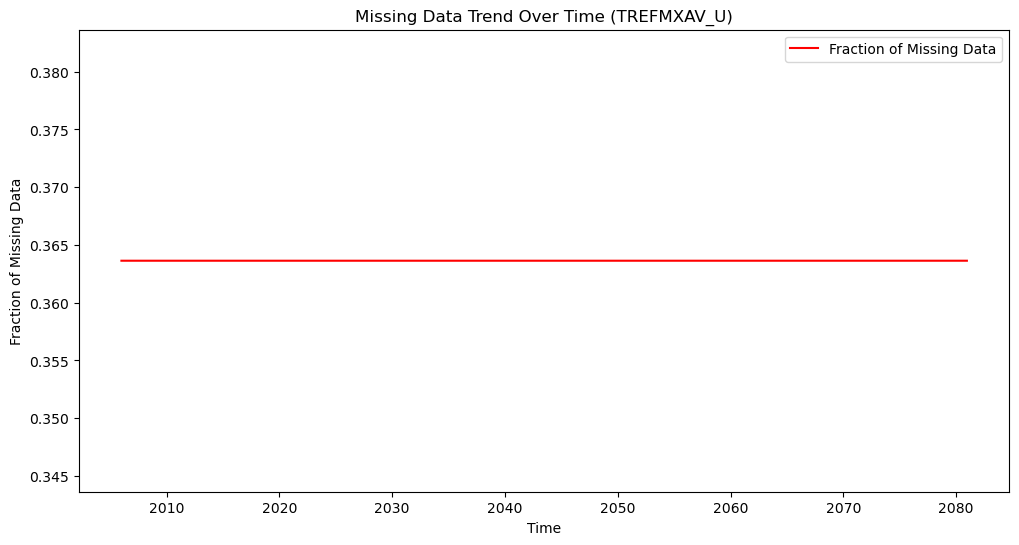

In [1888]:
# Compute fraction of missing data over time
missing_over_time = merged_dataset["TREFMXAV_U"].isnull().mean(dim=("lat", "lon"))

# Plot missing values trend
plt.figure(figsize=(12, 6))
plt.plot(merged_dataset["time"], missing_over_time, label="Fraction of Missing Data", color="red")
plt.xlabel("Time")
plt.ylabel("Fraction of Missing Data")
plt.title("Missing Data Trend Over Time (TREFMXAV_U)")
plt.legend()
plt.show()

Since the fraction of missing data remains constant over time, there is no time-dependent pattern (e.g., no sudden spikes or drops). This suggests that the missing data is randomly distributed rather than concentrated in specific months or years. If missing values occur randomly, then we can use simple imputation like mean, median, or forward fill.

In [1892]:
# Count consecutive missing values to determine gap sizes

# Get missing data mask (True where NaN, False where valid data)
missing_mask = merged_dataset["TREFMXAV_U"].isnull().values

# Find lengths of consecutive missing values
missing_gaps = []
current_gap = 0

for is_missing in missing_mask.flatten():  # Flatten to check across all lat/lon/time
    if is_missing:
        current_gap += 1  # Increase gap size
    else:
        if current_gap > 0:
            missing_gaps.append(current_gap)  # Store completed gap
        current_gap = 0  # Reset counter

# Include last gap if dataset ended on a missing value sequence
if current_gap > 0:
    missing_gaps.append(current_gap)

# Compute statistics on missing value gaps
gap_sizes = np.array(missing_gaps)
gap_summary = {
    "Total Gaps": len(gap_sizes),
    "Min Gap Size": gap_sizes.min() if len(gap_sizes) > 0 else 0,
    "Max Gap Size": gap_sizes.max() if len(gap_sizes) > 0 else 0,
    "Mean Gap Size": gap_sizes.mean() if len(gap_sizes) > 0 else 0,
    "Median Gap Size": np.median(gap_sizes) if len(gap_sizes) > 0 else 0
}

gap_summary

{'Total Gaps': 218993,
 'Min Gap Size': np.int64(1),
 'Max Gap Size': np.int64(7),
 'Mean Gap Size': np.float64(2.9999863009319934),
 'Median Gap Size': np.float64(2.0)}

Since the mean and median gap sizes are small (2-3 time steps missing at a time), forward fill will work well because it smoothly carries forward the most recent valid value. The maximum gap size is 7, which is not too large, meaning ffill() will not introduce major bias.

In [1896]:
# Apply forward fill only to TREFMXAV_U (good for time-series data)

# Step 1: Check if some locations have only NaN TREFMAX_U values across all time steps
nan_only_locations = np.sum(merged_dataset["TREFMXAV_U"].isnull().all(dim="time")).item()
print(f" Locations where all time values are NaN: {nan_only_locations}")

 Locations where all time values are NaN: 24


In [1897]:
# Step 2: If there are NaN-only locations, fill them with the global mean before applying forward fill
if nan_only_locations > 0:
    print("Some locations have no valid data. Filling them with global mean before forward filling.")
    
    # Compute global mean ignoring NaNs
    global_mean = merged_dataset["TREFMXAV_U"].mean(skipna=True)
    
    # Fill all-NaN locations with global mean
    merged_dataset["TREFMXAV_U"] = merged_dataset["TREFMXAV_U"].fillna(global_mean)

Some locations have no valid data. Filling them with global mean before forward filling.


In [1899]:
# Step 3: Apply forward fill along time
merged_dataset["TREFMXAV_U"] = merged_dataset["TREFMXAV_U"].ffill(dim="time")

In [1900]:
# Step 4: Verify if missing values are filled after the fix
missing_after_ffill = merged_dataset["TREFMXAV_U"].isnull().sum().item()
print(f" Missing values after applying global mean & forward fill: {missing_after_ffill}")

 Missing values after applying global mean & forward fill: 0


##### 3c. Duplicates

In [1902]:
# Convert dataset to Pandas DataFrame, keeping time, lat, lon
df = merged_dataset.to_dataframe().reset_index()

# Check duplicates considering ALL dimensions (time, lat, lon)
duplicate_entries = df.duplicated(subset=["time", "lat", "lon"]).sum()

print(f"Number of duplicated (identical time, lat, lon) rows: {duplicate_entries}")

Number of duplicated (identical time, lat, lon) rows: 0


In [1904]:
# Check for fully duplicated rows (exact copies)
duplicate_rows = df.duplicated().sum()
print(f"Number of fully duplicated rows: {duplicate_rows}")

Number of fully duplicated rows: 0


##### 3d. Convert temperature from Kelvin to Celcius

In [1907]:
# Convert temperature variables to Celsius
if "TREFHT" in merged_dataset:
    merged_dataset["TREFHT"] = merged_dataset["TREFHT"] - 273.15  # Convert daily average temperature

if "TREFMXAV_U" in merged_dataset:
    merged_dataset["TREFMXAV_U"] = merged_dataset["TREFMXAV_U"] - 273.15  # Convert max temperature

print("Temperature converted to Celsius.")

Temperature converted to Celsius.


##### 3e. Check negative values

In [1912]:
# Count negative values per variable
negative_values = {var: (merged_dataset[var] < 0).sum().item() for var in merged_dataset.data_vars}

# Display the count of negative values
for var, count in negative_values.items():
    print(f"Variable {var} has {count} negative values.")

Variable TREFMXAV_U has 0 negative values.
Variable FLNS has 0 negative values.
Variable FSNS has 0 negative values.
Variable PRECT has 0 negative values.
Variable PRSN has 45477 negative values.
Variable QBOT has 0 negative values.
Variable TREFHT has 32 negative values.
Variable UBOT has 321918 negative values.
Variable VBOT has 442240 negative values.


In [1914]:
# PRSN cant be negative. Negative PRSN means no snowfall occurred. Replace negative PRSN with 0
merged_dataset["PRSN"] = merged_dataset["PRSN"].where(merged_dataset["PRSN"] >= 0, 0)

In [1915]:
# TREFHT can be negative in cold climates. Out of 32 negative values, check their range. 
# If values are just slightly negative, they are valid (keep them)

# Find the most negative and least negative values
min_neg_trefht = merged_dataset["TREFHT"].where(merged_dataset["TREFHT"] < 0).min().item()
max_neg_trefht = merged_dataset["TREFHT"].where(merged_dataset["TREFHT"] < 0).max().item()

print(f"Most Negative TREFHT: {min_neg_trefht}°C")
print(f"Least Negative TREFHT: {max_neg_trefht}°C")

Most Negative TREFHT: -1.5244140625°C
Least Negative TREFHT: -0.02105712890625°C


##### 3f. Check if TREFMAX_U is always greater than TREFHT

In [1917]:
# Identify cases where TREFMXAV_U == TREFHT
# If it's rarely happen, then can ignore
equal_cases = (merged_dataset["TREFMXAV_U"] == merged_dataset["TREFHT"]).sum().item()

print(f"TREFMXAV_U is exactly equal to TREFHT in {equal_cases} cases.")

TREFMXAV_U is exactly equal to TREFHT in 0 cases.


In [1919]:
# Identify if TREFMXAV_U < TREFHT
violation = merged_dataset.where(merged_dataset["TREFMXAV_U"] < merged_dataset["TREFHT"])

# Count the number of violations
num_violation = violation["TREFMXAV_U"].count().item()

# Display results
if num_violation == 0:
    print("TREFMXAV_U is ALWAYS greater than TREFHT.")
else:
    print(f"Found {num_violation} cases where TREFMXAV_U is less than TREFHT.")

Found 196499 cases where TREFMXAV_U is less than TREFHT.


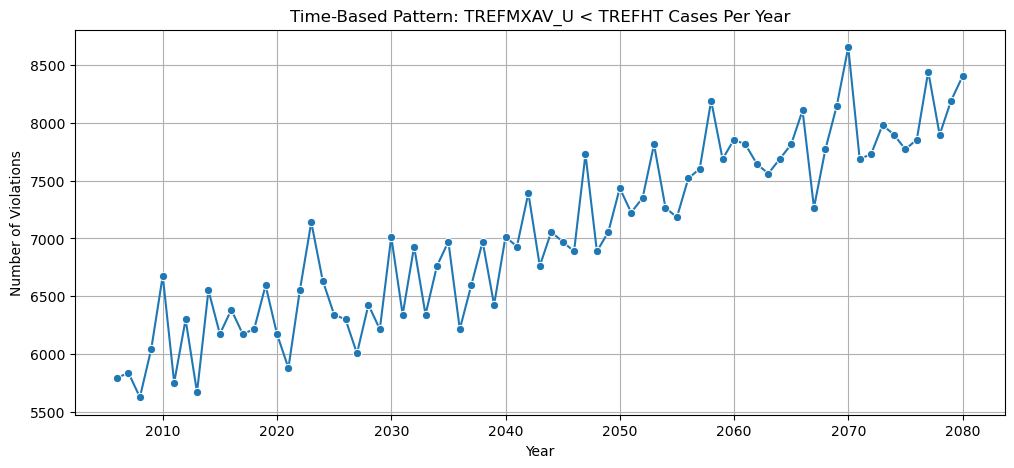

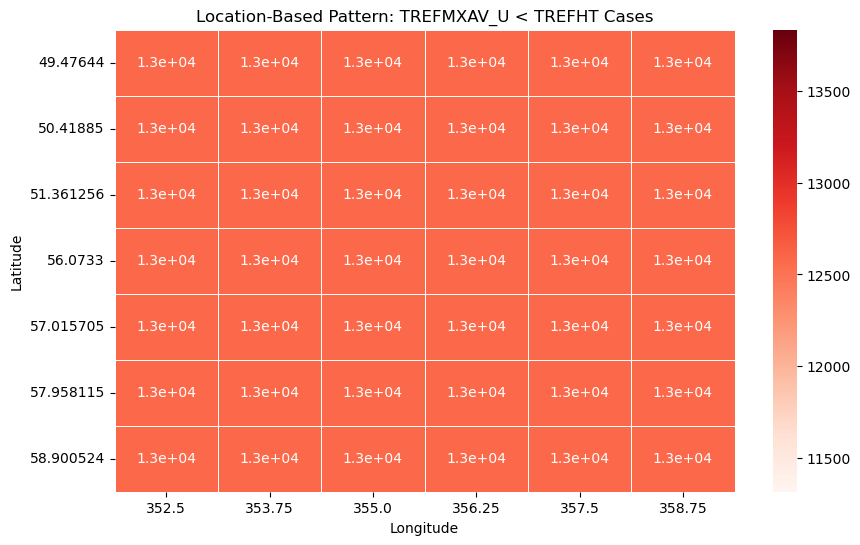

In [1928]:
# Check if there's any pattern in cases where TREFMAX_U < TREFHT

# Step 1: Identify where TREFMXAV_U is less than TREFHT
violation_mask = merged_dataset["TREFMXAV_U"] < merged_dataset["TREFHT"]

# Step 2: Convert violations to DataFrame
violations_df = merged_dataset.where(violation_mask, drop=True).to_dataframe().reset_index()

# Step 3: Time-Based Analysis
# Convert time to pandas datetime format
violations_df["year"] = pd.to_datetime(violations_df["time"]).dt.year

# Count number of violations per year
violations_per_year = violations_df["year"].value_counts().sort_index()

# Plot time-based pattern
plt.figure(figsize=(12, 5))
sns.lineplot(x=violations_per_year.index, y=violations_per_year.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Number of Violations")
plt.title("Time-Based Pattern: TREFMXAV_U < TREFHT Cases Per Year")
plt.grid()
plt.show()

# Step 4: Location-Based Analysis
# Count number of violations per latitude and longitude
violations_per_location = violations_df.groupby(["lat", "lon"]).size().reset_index(name="count")

# Pivot for heatmap
violations_pivot = violations_per_location.pivot(index="lat", columns="lon", values="count")

# Plot spatial distribution
plt.figure(figsize=(10, 6))
sns.heatmap(violations_pivot, cmap="Reds", linewidths=0.5, annot=True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Location-Based Pattern: TREFMXAV_U < TREFHT Cases")
plt.show()

The visualizations reveal that violations where TREFMAX_U < TREFHT occur consistently over time with a slightly increasing trend, suggesting that these cases are systematic rather than seasonal or location-dependent anomalies. The location-based heatmap shows that the violations are evenly distributed across different latitudes and longitudes, further indicating that the issue is widespread rather than isolated to specific regions. This suggests that the discrepancies are likely due to systematic data recording or processing errors rather than natural climate variations.

Small violations (0 to -1°C) are corrected by setting TREFMAX_U = TREFHT + 0.1°C, addressing minor inconsistencies without altering the dataset significantly. For large violations (< -1°C), a median-based correction with scaling ensures dynamic, data-driven adjustments while preserving distribution integrity. With no clear temporal or spatial pattern, these corrections effectively resolve discrepancies without introducing bias. The small adjustments maintain data accuracy, while the median-based approach handles larger errors based on overall dataset trends.

In [1932]:
# Identify small vs large violation

# Compute the difference between TREFMAX_U and TREFHT
diff = merged_dataset["TREFMXAV_U"] - merged_dataset["TREFHT"]

# Identify small and large violation
small_violation = (diff < 0) & (diff >= -1) # possible round up effect
large_violation = diff < -1

# Count the number of small and large violations
num_small_violation = small_violation.sum().item()
num_large_violation = large_violation.sum().item()

# Display results
print(f"Small violation (between 0 and -1):", num_small_violation)
print(f"Large violation (below -1):", num_large_violation)

Small violation (between 0 and -1): 50690
Large violation (below -1): 145809


In [1934]:
# Handling small violation

# Identify small violations (where the difference is between 0 and -1)
small_violation_mask = (diff < 0) & (diff >= -1)

# Fix small violations by ensuring TREFMAX_U is slightly higher than TREFHT
merged_dataset["TREFMXAV_U"] = merged_dataset["TREFMXAV_U"].where(
    ~small_violation_mask,  # Keep values where there's no small violation
    merged_dataset["TREFHT"] + 0.1  # Ensure TREFMAX_U is slightly higher
)

In [1936]:
# Recalculate difference to check if small violations are gone
final_diff = merged_dataset["TREFMXAV_U"] - merged_dataset["TREFHT"]
remaining_small = ((final_diff < 0) & (final_diff >= -1)).sum().item()
remaining_large = (final_diff < -1).sum().item()

# Display results
print(f"Final Small violations (between 0 and -1): {remaining_small}")
print(f"Final Large violations (below -1): {remaining_large}")

Final Small violations (between 0 and -1): 0
Final Large violations (below -1): 145809


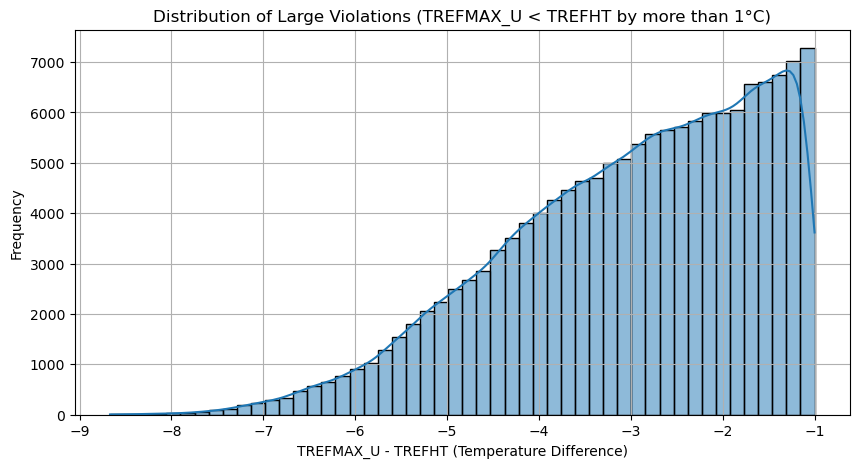

In [1938]:
# Plot the distribution of large violations
plt.figure(figsize=(10, 5))
sns.histplot(diff.where(large_violation, drop=True).values.flatten(), bins=50, kde=True)
plt.xlabel("TREFMAX_U - TREFHT (Temperature Difference)")
plt.ylabel("Frequency")
plt.title("Distribution of Large Violations (TREFMAX_U < TREFHT by more than 1°C)")
plt.grid()
plt.show()

In [1940]:
# Handling large vilation

# Compute the difference again
diff = merged_dataset["TREFMXAV_U"] - merged_dataset["TREFHT"]

# Identify large violations (TREFMAX_U < TREFHT by more than 1°C)
large_violation_mask = diff < -1

In [1942]:
# Compute correction factor using median of large violations only
large_violation_diff = diff.where(large_violation_mask, drop=True)  # Focus on large violations

# Check and print median before applying correction
median_before_correction = large_violation_diff.median().item()
print(f"Median of large violations before correction: {median_before_correction:.2f}°C")

Median of large violations before correction: -2.78°C


In [1944]:
# Compute scaled correction factor
scaling_factor = 0.3 # conservative approach
median_correction = np.abs(median_before_correction) * scaling_factor

# Apply correction
merged_dataset["TREFMXAV_U"] = merged_dataset["TREFMXAV_U"].where(
    ~large_violation_mask,
    merged_dataset["TREFHT"] + median_correction  # Adaptive correction
)

In [1946]:
# Final check
final_diff = merged_dataset["TREFMXAV_U"] - merged_dataset["TREFHT"]
remaining_small = ((final_diff < 0) & (final_diff >= -1)).sum().item()
remaining_large = (final_diff < -1).sum().item()

# Display results
print(f"Final Small violations (between 0 and -1): {remaining_small}")
print(f"Final Large violations (below -1): {remaining_large}")

Final Small violations (between 0 and -1): 0
Final Large violations (below -1): 0


In [1948]:
# Save the preprocessed dataset
merged_dataset.to_netcdf("preprocessed_merged_dataset.nc")